# **Overview of sktime's forecasting functionality**
## by Joanna Lenczuk

The code in this notebook is explained comprehensively in this article:
https://towardsdatascience.com/why-start-using-sktime-for-forecasting-8d6881c0a518

In [1]:
# %%capture
# !pip install numpy
# !pip install pandas
# !pip install seaborn
# !pip install 'sktime[all_extras]'

In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import sktime
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    DirectTabularRegressionForecaster,
    EnsembleForecaster,
    ForecastingPipeline,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    ForecastingRandomizedSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import (
    MedianAbsolutePercentageError,
    make_forecasting_scorer,
    mean_absolute_scaled_error,
    median_absolute_percentage_error,
)
from sktime.transformations.compose import OptionalPassthrough
from sktime.transformations.series.boxcox import BoxCoxTransformer, LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.transformations.series.outlier_detection import HampelFilter
from sktime.utils.plotting import plot_series

In [3]:
sktime.__version__

'0.30.1'

In [4]:
warnings.filterwarnings("ignore")

In [5]:
sns.set(rc={"figure.figsize": (12, 6)})

### Importing data

In [6]:
df = sm.datasets.macrodata.load_pandas()["data"]

In [7]:
df.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


### Data overview

Dataset contains USA quarterly macroeconomic data between 1959 and 2009.

**Target variable - `realgdp`**

In [8]:
df["q_date"] = df.apply(
    lambda x: str(int(x["year"])) + "-" + "Q" + str(int(x["quarter"])), axis=1
)
df["date"] = pd.PeriodIndex(df["q_date"], freq="Q").to_timestamp()

In [9]:
df.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,q_date,date
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00,1959-Q1,1959-01-01
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74,1959-Q2,1959-04-01
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09,1959-Q3,1959-07-01
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06,1959-Q4,1959-10-01
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19,1960-Q1,1960-01-01


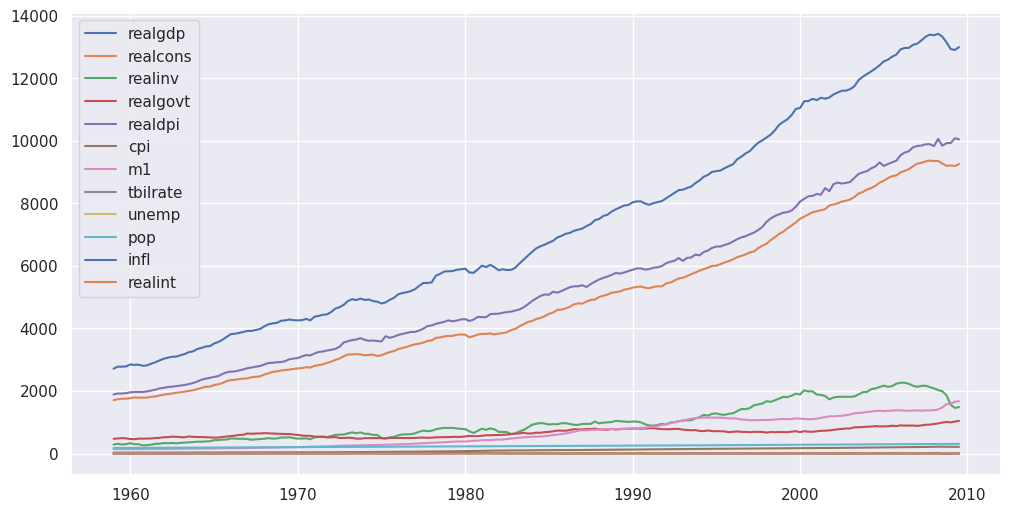

In [10]:
for val in df.columns[2:14]:
    plt.plot(df.date, df[val], label=val)
plt.legend();

In [11]:
df.columns

Index(['year', 'quarter', 'realgdp', 'realcons', 'realinv', 'realgovt',
       'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint',
       'q_date', 'date'],
      dtype='object')

In [12]:
df = df.set_index("date").to_period("Q")
df.index

PeriodIndex(['1959Q1', '1959Q2', '1959Q3', '1959Q4', '1960Q1', '1960Q2',
             '1960Q3', '1960Q4', '1961Q1', '1961Q2',
             ...
             '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3',
             '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', name='date', length=203)

## 1. Unified API

### Basic forecasters interface

In [13]:
y = df["realgdp"]
y_train, y_test = temporal_train_test_split(y, test_size=30)

In [14]:
forecaster = NaiveForecaster()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh=1)  # forecasting one step ahead

In [15]:
y_pred

2002Q2    11477.868
Freq: Q-DEC, Name: realgdp, dtype: float64

### Forecasting horizons

In [16]:
fh_abs = ForecastingHorizon(y_test.index, is_relative=False)  # specific data points
fh_abs

ForecastingHorizon(['2002Q2', '2002Q3', '2002Q4', '2003Q1', '2003Q2', '2003Q3',
             '2003Q4', '2004Q1', '2004Q2', '2004Q3', '2004Q4', '2005Q1',
             '2005Q2', '2005Q3', '2005Q4', '2006Q1', '2006Q2', '2006Q3',
             '2006Q4', '2007Q1', '2007Q2', '2007Q3', '2007Q4', '2008Q1',
             '2008Q2', '2008Q3', '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', name='date', is_relative=False)

**Forecasts on the test set**

In [17]:
# cutoff is the last point in the training series
cutoff = pd.Period("2002-01-01", freq="Q")

# forecasting 1, 2, ..., 30 steps ahead of the last point in the training series
fh_rel = fh_abs.to_relative(cutoff)
fh_rel

ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
      dtype='int64', is_relative=True)

**In-sample forecasts**

In [18]:
# cutoff is 29 quarters after the last point in the training series
cutoff_insample = pd.Period("2009-09-01", freq="Q")

# forecasting 0, 1, ..., 29 steps before the last point in the training series
fh_rel_insample = fh_abs.to_relative(cutoff_insample)
fh_rel_insample

ForecastingHorizon([-29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16,
       -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,
        -1,   0],
      dtype='int64', is_relative=True)

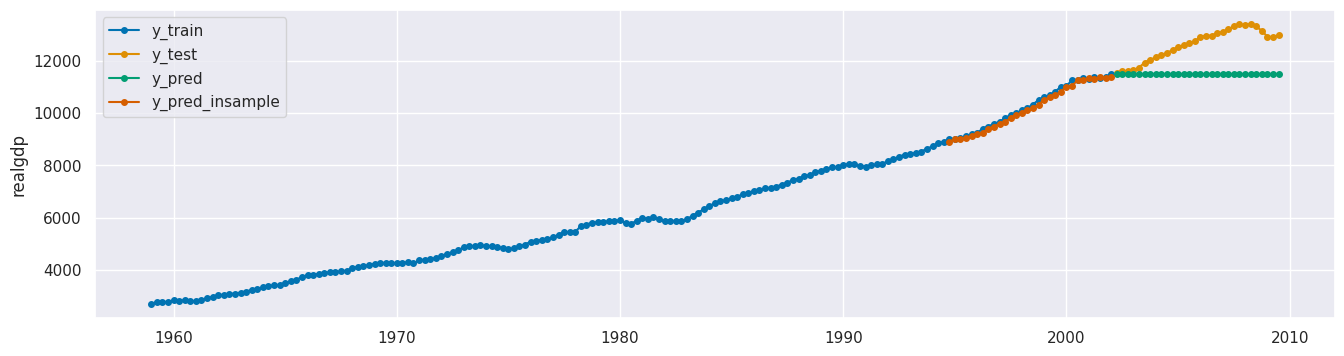

In [19]:
forecaster = NaiveForecaster()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh=fh_rel)
y_pred_insample = forecaster.predict(fh=fh_rel_insample)

plot_series(
    y_train,
    y_test,
    y_pred,
    y_pred_insample,
    labels=["y_train", "y_test", "y_pred", "y_pred_insample"],
);

**Forward forecasts**

In [20]:
# cutoff is 12 quarters before the last point in the training series
cutoff_forward = pd.Period("1999-01-01", freq="Q")

# forecasting 13, 14, ..., 42 steps after the last point in the training series
fh_rel_forward = fh_abs.to_relative(cutoff_forward)
fh_rel_forward

ForecastingHorizon([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42],
      dtype='int64', is_relative=True)

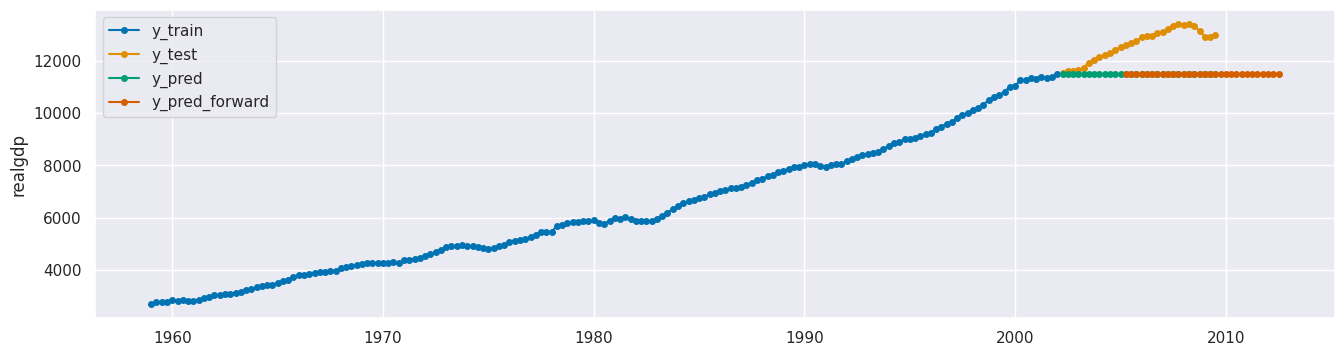

In [21]:
forecaster = NaiveForecaster()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh=fh_rel)
y_pred_forward = forecaster.predict(fh=fh_rel_forward)

plot_series(
    y_train,
    y_test,
    y_pred,
    y_pred_forward,
    labels=["y_train", "y_test", "y_pred", "y_pred_forward"],
);

### Univariate time series

MASE: 2.864


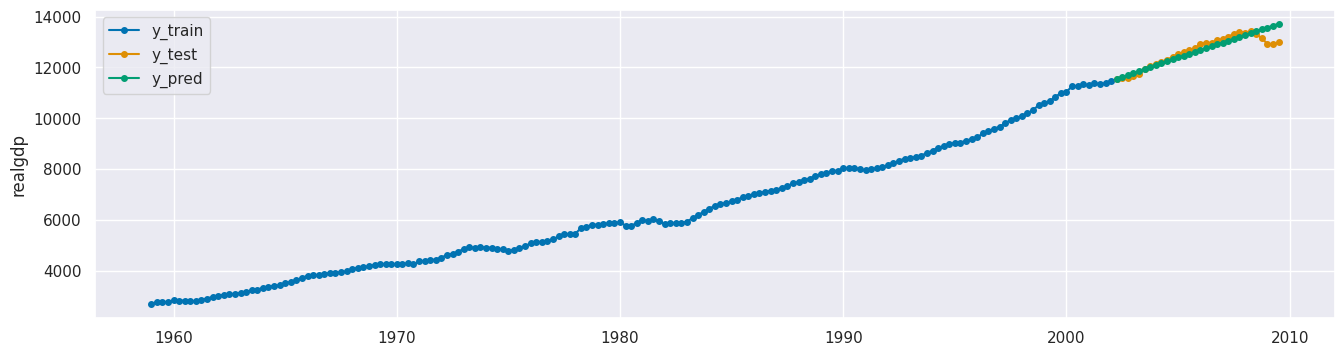

In [88]:
y = df["realgdp"]
y_train, y_test = temporal_train_test_split(y, test_size=30)

forecaster = AutoARIMA(sp=4)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh=fh_abs)

mase = mean_absolute_scaled_error(y_true=y_test, y_pred=y_pred, y_train=y_train)
print(f"MASE: {round(mase,3)}")
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

MASE: 5.496


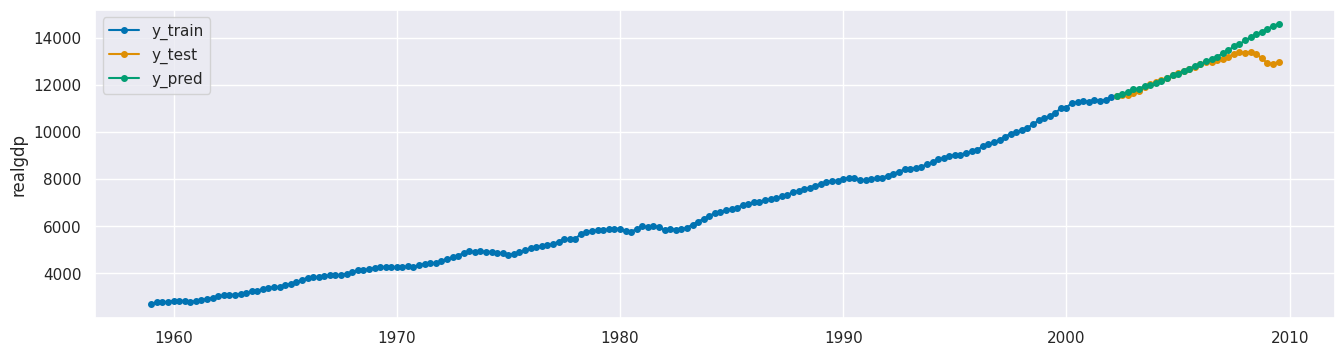

In [89]:
y = df["realgdp"]
y_train, y_test = temporal_train_test_split(y, test_size=30)

forecaster = DirectTabularRegressionForecaster(LinearRegression())
forecaster.fit(
    y_train, fh=fh_abs
)  # forecasting horizon necessary in the fit() method for this forecaster
y_pred = forecaster.predict()

mase = mean_absolute_scaled_error(y_true=y_test, y_pred=y_pred, y_train=y_train)
print(f"MASE: {round(mase,3)}")
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

### Multivariate exogenous time series
Forecasting with exogenous variables (i.e. multivariate X)

In [24]:
# creating lagged values to avoid data leakage
df.loc[:, "realinv_lagged"] = df.loc[:, "realinv"].shift()
df[["realinv_lagged"]] = df[["realinv_lagged"]].fillna(method="backfill")

MASE: 6.708


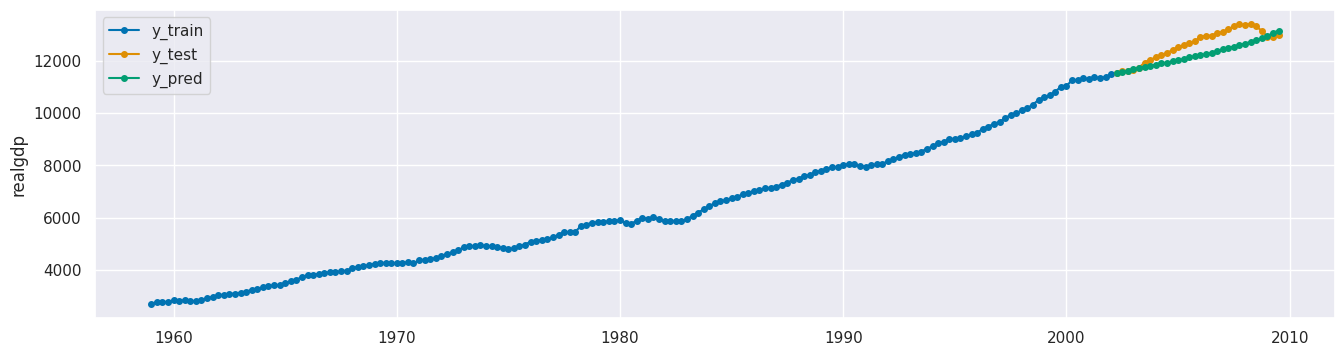

In [25]:
y = df["realgdp"]
X = df[["realinv_lagged"]]  # could be more features
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, fh=fh_abs)

forecaster = AutoARIMA(sp=4)
forecaster.fit(y_train, X_train)
y_pred = forecaster.predict(X=X_test, fh=fh_abs)

mase = mean_absolute_scaled_error(y_true=y_test, y_pred=y_pred, y_train=y_train)
print(f"MASE: {round(mase,3)}")
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

### Updating a forecaster

In [26]:
y_old_data = y_train[:-4]
forecaster = AutoARIMA(sp=4)
forecaster.fit(y_old_data)
y_old_pred = forecaster.predict(fh_rel)

In [27]:
# updating the model with new data (full year) and generating predictions
# for the next period
y_new_data = y_train[-4:]
forecaster.update(y_new_data)
y_new_pred = forecaster.predict(fh_rel)

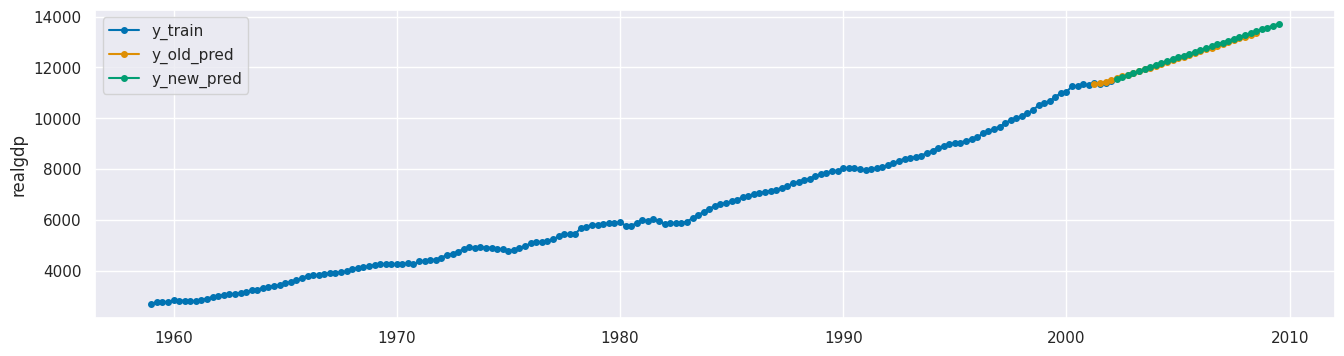

In [28]:
plot_series(
    y_train, y_old_pred, y_new_pred, labels=["y_train", "y_old_pred", "y_new_pred"]
);

## 2. Reducing a forecasting task to a regression problem

MASE: 4.104


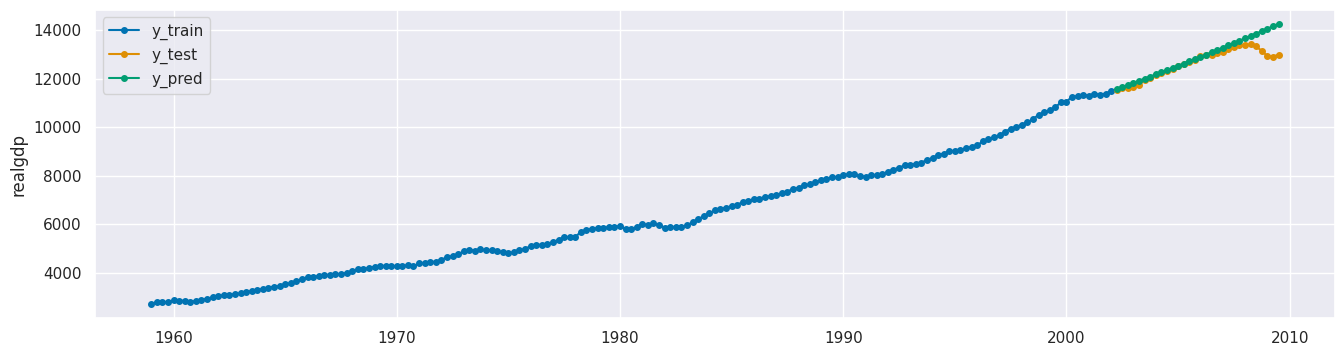

In [29]:
regressor = LinearRegression()
forecaster = make_reduction(estimator=regressor, strategy="recursive", window_length=4)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh_abs)

mase = mean_absolute_scaled_error(y_true=y_test, y_pred=y_pred, y_train=y_train)
print(f"MASE: {round(mase,3)}")
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

MASE: 4.984


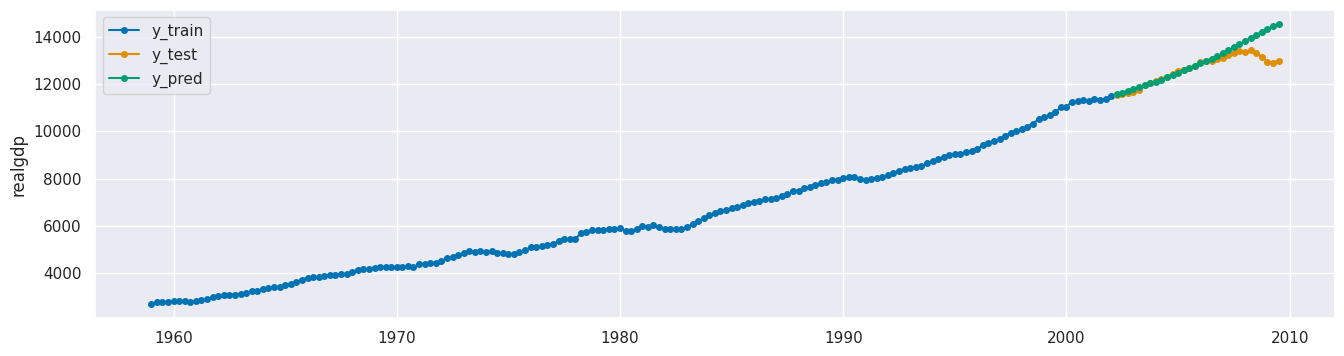

In [30]:
# direct reduction strategy
regressor = LinearRegression()
forecaster = DirectTabularRegressionForecaster(estimator=regressor, window_length=4)
forecaster.fit(y=y_train, fh=fh_abs)
y_pred = forecaster.predict()

mase = mean_absolute_scaled_error(y_true=y_test, y_pred=y_pred, y_train=y_train)
print(f"MASE: {round(mase,3)}")
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

## 3. Evaluation of forecasting models

### Performance metrics

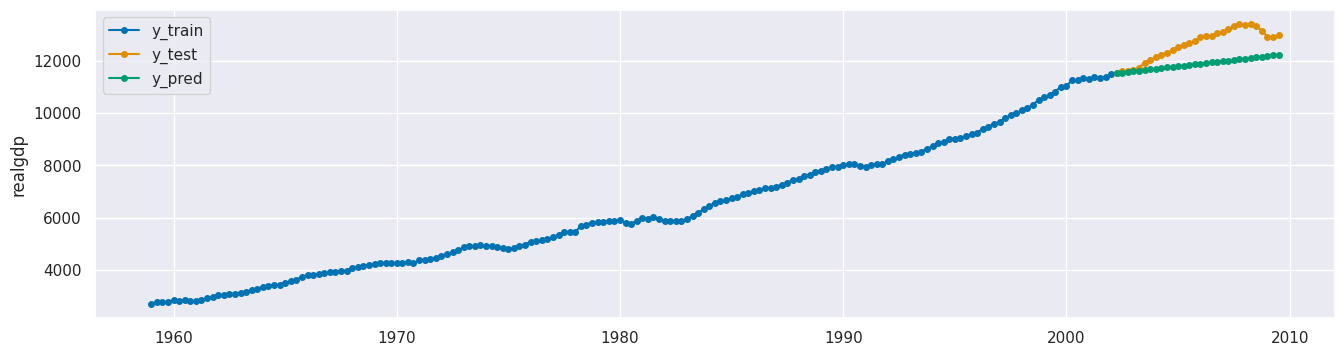

In [31]:
forecaster = ThetaForecaster()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh=fh_abs)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [32]:
# MdAPE function
median_absolute_percentage_error(y_test, y_pred)

0.06012960019008075

In [33]:
# MdAPE class
mdape = MedianAbsolutePercentageError()
mdape(y_true=y_test, y_pred=y_pred)

0.06012960019008075

In [34]:
def custom_mape(y_true: np.array, y_pred: np.array, multioutput: str):
    metrics_dict = {
        "uniform_average": np.mean(np.abs((y_true - np.ceil(y_pred)) / y_true)),
        "raw_values": np.abs((y_true - np.ceil(y_pred)) / y_true),
    }
    try:
        return metrics_dict[multioutput]
    except KeyError:
        print(
            "multioutput specified incorrectly - pick `raw_values` or `uniform_average`"
        )

In [35]:
mape_changed = make_forecasting_scorer(func=custom_mape, multioutput="uniform_average")
mape_changed(y_test, y_pred)

0.05751249071487726

In [36]:
mape_changed = make_forecasting_scorer(func=custom_mape, multioutput="raw_values")
mape_changed(y_test, y_pred)

array([0.00102004, 0.00391758, 0.002054  , 0.00402024, 0.00977161,
       0.02408462, 0.03079155, 0.03550762, 0.04034922, 0.04539615,
       0.05159286, 0.0590479 , 0.06113469, 0.0663205 , 0.06915992,
       0.07935452, 0.08080733, 0.07912407, 0.08396799, 0.08487858,
       0.09019835, 0.09639655, 0.09933719, 0.0958987 , 0.09729706,
       0.08935353, 0.07486882, 0.05743802, 0.05383124, 0.05845428])

### Time-based cross-validation

- **Expanding Window**

In [37]:
forecaster = AutoARIMA(sp=4)
cv = ExpandingWindowSplitter(step_length=30, fh=list(range(1, 31)), initial_window=40)
cv_df = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="update", return_data=True)

In [38]:
cv_df

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.027279,4.053660,0.014372,40,1968Q4,date 1959Q1 2710.349 1959Q2 2778.801 195...,date 1969Q1 4244.100 1969Q2 4256.460 196...,1969Q1 4211.384583 1969Q2 4248.007673 19...
1,0.022458,2.979999,0.020072,70,1976Q2,date 1959Q1 2710.349 1959Q2 2778.801 195...,date 1976Q3 5154.072 1976Q4 5191.499 197...,1976Q3 5183.195992 1976Q4 5222.693348 19...
2,0.059587,3.951887,0.013856,100,1983Q4,date 1959Q1 2710.349 1959Q2 2778.801 195...,date 1984Q1 6448.264 1984Q2 6559.594 198...,1984Q1 6385.598862 1984Q2 6428.366855 19...
3,0.049360,2.750728,0.013150,130,1991Q2,date 1959Q1 2710.349 1959Q2 2778.801 195...,date 1991Q3 8037.538 1991Q4 8069.046 1...,1991Q3 8048.706257 1991Q4 8090.890623 19...
4,0.009310,6.476974,0.013120,160,1998Q4,date 1959Q1 2710.349 1959Q2 2778.801 1...,date 1999Q1 10601.179 1999Q2 10684.049 1...,1999Q1 10623.174768 1999Q2 10727.402350 ...


Average MAPE with Expanding Window: 0.034


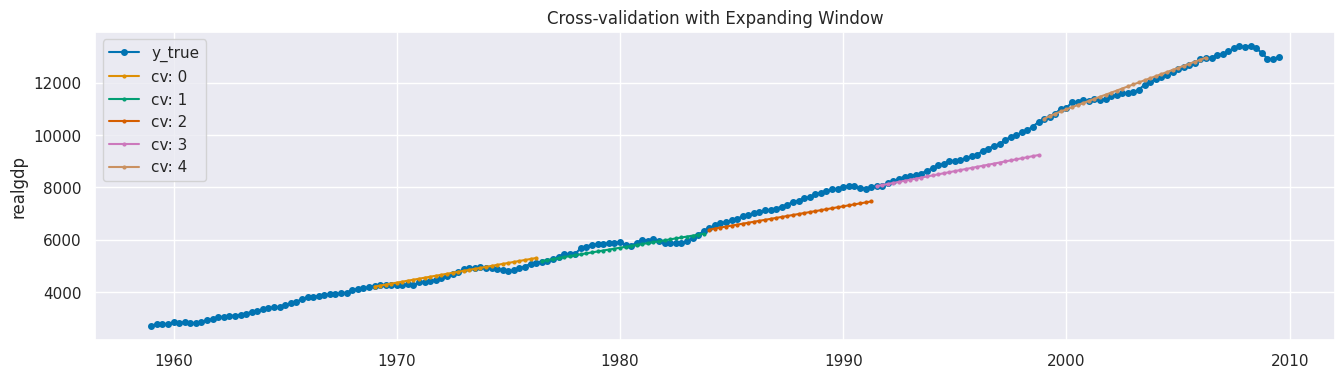

In [39]:
plot_series(
    y,
    *[cv_df["y_pred"].iloc[x] for x in range(5)],
    markers=["o", *["."] * 5],
    labels=["y_true"] + [f"cv: {x}" for x in range(5)],
)
avg_mape = cv_df["test_MeanAbsolutePercentageError"].mean()
print(f"Average MAPE with Expanding Window: {round(avg_mape, 3)}")
plt.title("Cross-validation with Expanding Window");

- **Sliding Window**

In [40]:
forecaster = AutoARIMA(sp=4)
cv = SlidingWindowSplitter(step_length=30, fh=list(range(1, 31)), initial_window=40)
cv_df = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="update", return_data=True)

In [41]:
cv_df

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.027279,2.256164,0.014505,40,1968Q4,1959Q1 2710.349 1959Q2 2778.801 1959Q3 ...,1969Q1 4244.100 1969Q2 4256.460 1969Q3 ...,1969Q1 4211.384583 1969Q2 4248.007673 19...
1,0.032508,1.489405,0.013682,10,1976Q2,1974Q1 4909.617 1974Q2 4922.188 1974Q3 ...,1976Q3 5154.072 1976Q4 5191.499 1977Q1 ...,1976Q3 5178.306143 1976Q4 5227.665286 19...
2,0.017365,1.455419,0.014484,10,1983Q4,1981Q3 6030.184 1981Q4 5955.062 1982Q1 ...,1984Q1 6448.264 1984Q2 6559.594 1984Q3 ...,1984Q1 6386.849 1984Q2 6448.124 1984Q3 ...
3,0.011343,1.464254,0.013631,10,1991Q2,1989Q1 7806.603 1989Q2 7865.016 1989Q3 ...,1991Q3 8037.538 1991Q4 8069.046 1992Q1...,1991Q3 8080.539 1991Q4 8157.256 1992Q1...
4,0.052317,18.400347,0.013599,10,1998Q4,1996Q3 9488.879 1996Q4 9592.458 1997Q1...,1999Q1 10601.179 1999Q2 10684.049 1999Q3...,1999Q1 10749.487249 1999Q2 10779.693065 ...


Average MAPE with Sliding Window: 0.028


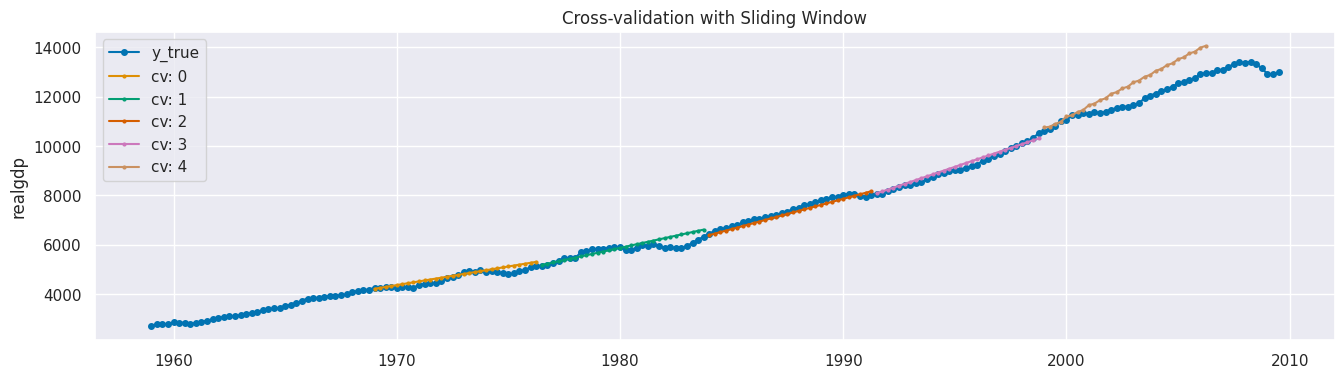

In [42]:
plot_series(
    y,
    *[cv_df["y_pred"].iloc[x] for x in range(5)],
    markers=["o", *["."] * 5],
    labels=["y_true"] + [f"cv: {x}" for x in range(5)],
)
avg_mape = cv_df["test_MeanAbsolutePercentageError"].mean()
print(f"Average MAPE with Expanding Window: {round(avg_mape, 3)}")
plt.title("Cross-validation with Sliding Window");

### Tuning

- **Grid Search with a statistical model**

In [43]:
forecaster = AutoETS(sp=4, allow_multiplicative_trend=True)
params = {"trend": ["add", "mul"], "damped_trend": [True, False]}

In [44]:
cv = SlidingWindowSplitter(initial_window=60, window_length=30)
fgs = ForecastingGridSearchCV(forecaster, strategy="refit", cv=cv, param_grid=params)

In [45]:
fgs.fit(y_train)
y_pred = fgs.predict(fh_abs)

/usr/local/share/python/env/sktime_prod_loader/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/share/python/env/sktime_prod_loader/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [46]:
fgs.best_params_

{'damped_trend': False, 'trend': 'add'}

In [47]:
fgs.best_score_

0.00674066038278309

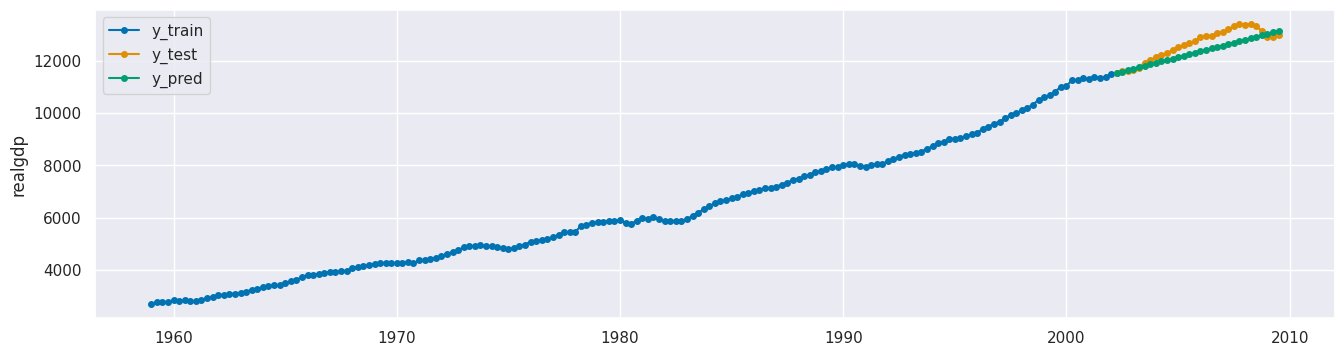

In [48]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

- **Randomized Search with a scikit-learn estimator**

In [49]:
regressor = LinearRegression()
forecaster = make_reduction(regressor, strategy="recursive")
params = {"window_length": list(range(2, 21))}

In [50]:
cv = SlidingWindowSplitter(initial_window=60, window_length=30)
frs = ForecastingRandomizedSearchCV(
    forecaster,
    strategy="refit",
    cv=cv,
    param_distributions=params,
    n_iter=5,
    random_state=42,
)

In [51]:
frs.fit(y_train)
y_pred = frs.predict(fh_abs)

In [52]:
frs.best_params_

{'window_length': 2}

In [53]:
frs.best_score_

0.006820844800594237

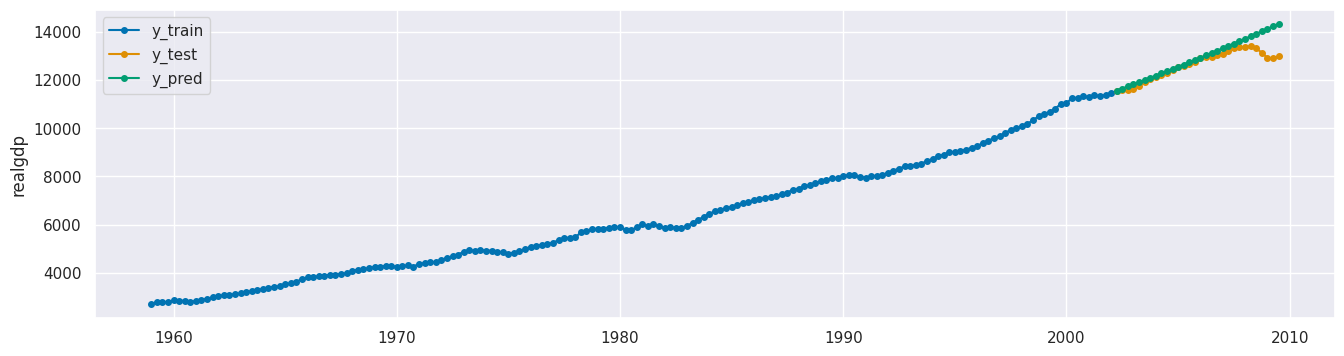

In [54]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

- **Tuning nested parameters**

Random Forest Regressor

In [55]:
regressor = RandomForestRegressor(n_estimators=20)
forecaster = make_reduction(regressor)

In [56]:
forecaster.get_params()

{'estimator': RandomForestRegressor(n_estimators=20),
 'pooling': 'local',
 'transformers': None,
 'window_length': 10,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'squared_error',
 'estimator__max_depth': None,
 'estimator__max_features': 1.0,
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__monotonic_cst': None,
 'estimator__n_estimators': 20,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False}

In [57]:
nested_params = {
    "window_length": list(range(2, 21)),
    "estimator__max_depth": list(range(5, 16)),
}

In [58]:
cv = SlidingWindowSplitter(initial_window=60, window_length=30)
nrcv = ForecastingRandomizedSearchCV(
    forecaster,
    strategy="refit",
    cv=cv,
    param_distributions=nested_params,
    n_iter=5,
    random_state=42,
)

In [59]:
nrcv.fit(y_train)
y_pred = nrcv.predict(fh_abs)

In [60]:
nrcv.best_params_

{'window_length': 5, 'estimator__max_depth': 8}

In [61]:
nrcv.best_score_

0.013795558308396877

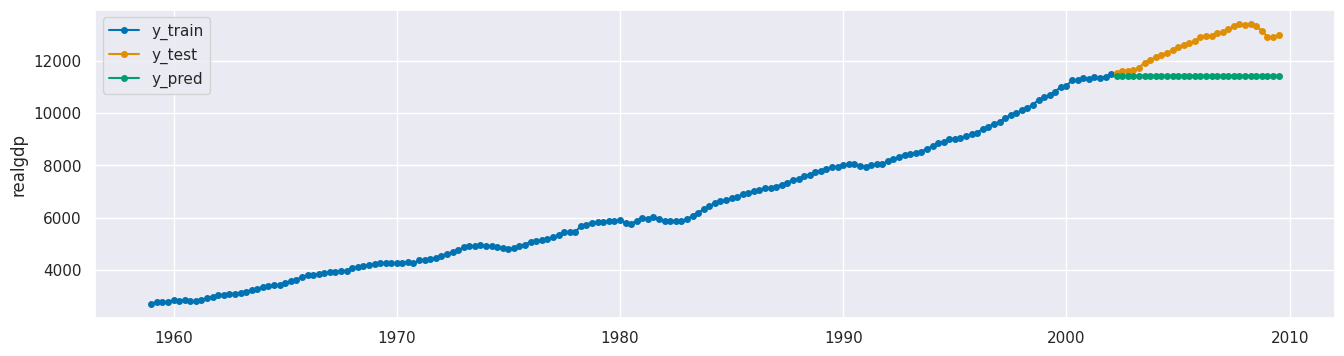

In [62]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

## 4. New forecasting functionalities

### Transformers

**`Deseasonalizer`**

In [63]:
transformer = Deseasonalizer(sp=4)  # removing seasonality
y_train_transformed = transformer.fit_transform(y_train)

In [64]:
y_train_inversed = transformer.inverse_transform(
    y_train_transformed
)  # inversing the seasonality removal

In [65]:
# after inversing the transformation, values are again on the same scale as before
(np.round(y_train.values, 3) == np.round(y_train_inversed.values, 3)).all()

True

**`BoxCoxTransformer`**

In [66]:
forecaster = ThetaForecaster(sp=4)
transformer = BoxCoxTransformer(sp=4)  # Box-Cox power transformation
y_train_transformed = transformer.fit_transform(y_train)

In [67]:
forecaster.fit(y_train_transformed)
y_pred = forecaster.predict(fh=fh_abs)
y_pred_inversed = transformer.inverse_transform(y_pred)

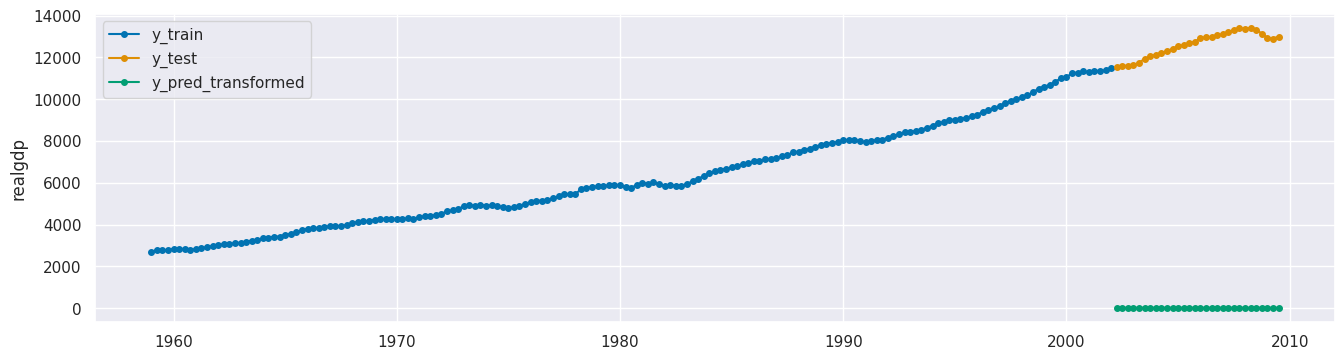

In [68]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred_transformed"]);

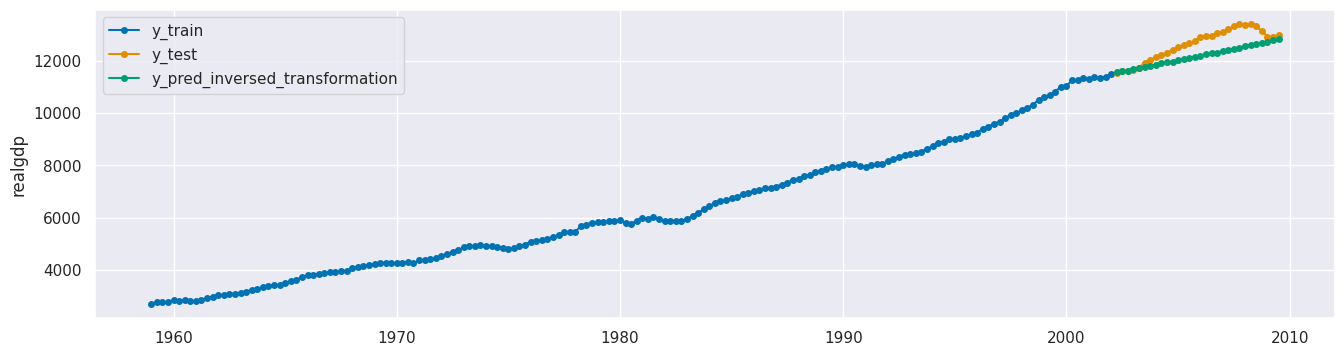

In [69]:
plot_series(
    y_train,
    y_test,
    y_pred_inversed,
    labels=["y_train", "y_test", "y_pred_inversed_transformation"],
);

### Pipelines

- **`TransformedTargetForecaster` - simple pipeline**

In [70]:
# two transformers and a forecaster
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(sp=4)),
        ("box_cox", BoxCoxTransformer(sp=4)),
        ("forecast", ThetaForecaster(sp=4)),
    ]
)

In [71]:
forecaster.fit(y_train)
y_pred = forecaster.predict(fh_abs)

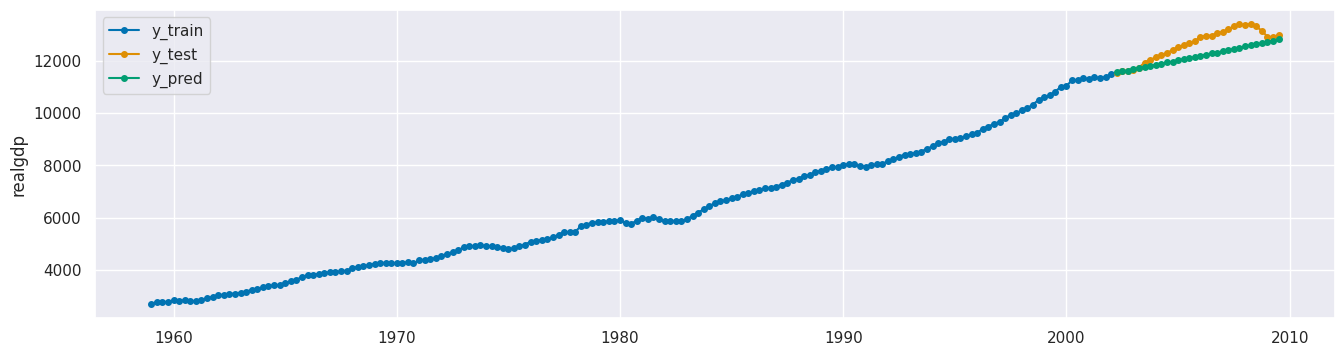

In [72]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

- **ForecastingPipeline - pipeline with exogenous variables**

In [73]:
forecaster = ForecastingPipeline(
    [
        ("hampel", HampelFilter()),
        ("log", LogTransformer()),
        ("forecaster", ThetaForecaster(sp=4)),
    ]
)

In [74]:
X_train = X_test = None  # to silence linter complaints; not used in this example
forecaster.fit(y_train, X_train)
y_pred = forecaster.predict(fh=fh_abs, X=X_test)

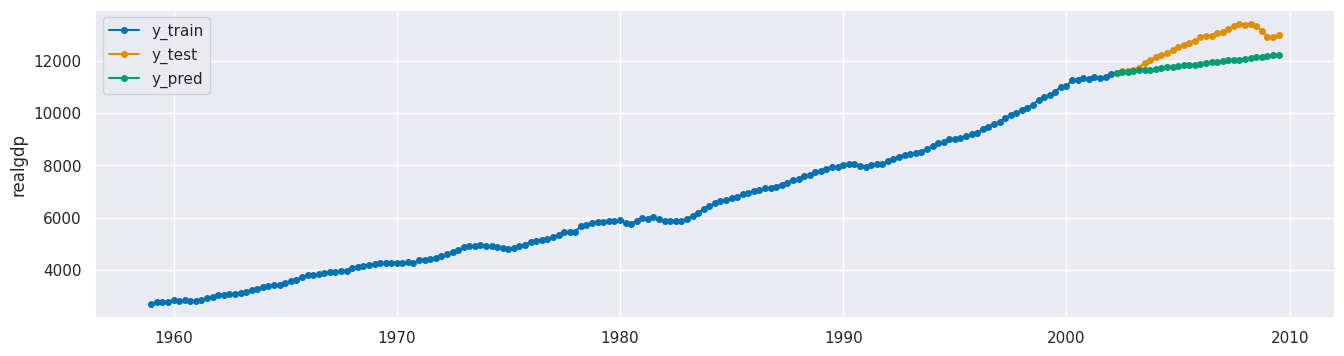

In [75]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

### Automated model selection

- **`MultiplexForecaster` - finding the best forecaster**

In [76]:
forecaster = MultiplexForecaster(
    forecasters=[
        ("theta", ThetaForecaster(sp=4)),
        ("ets", ExponentialSmoothing(trend="add", sp=4)),
        ("autoarima", AutoARIMA(sp=4)),
    ],
)

In [77]:
cv = SlidingWindowSplitter(initial_window=60, window_length=30)
forecaster_param_grid = {"selected_forecaster": ["theta", "ets", "autoarima"]}
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

In [78]:
gscv.fit(y_train)

/home/ericb/GitHub/prod/sktime/sktime/utils/datetime.py:73: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/home/ericb/GitHub/prod/sktime/sktime/utils/datetime.py:73: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/home/ericb/GitHub/prod/sktime/sktime/utils/datetime.py:73: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/home/ericb/GitHub/prod/sktime/sktime/utils/datetime.py:73: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/home/ericb/GitHub/prod/sktime/sktime/utils/datetime.py:73: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  off

ForecastingGridSearchCV(cv=SlidingWindowSplitter(initial_window=60,
                                                 window_length=30),
                        forecaster=MultiplexForecaster(forecasters=[('theta',
                                                                     ThetaForecaster(sp=4)),
                                                                    ('ets',
                                                                     ExponentialSmoothing(sp=4,
                                                                                          trend='add')),
                                                                    ('autoarima',
                                                                     AutoARIMA(sp=4))]),
                        param_grid={'selected_forecaster': ['theta', 'ets',
                                                            'autoarima']})

In [79]:
gscv.best_params_

{'selected_forecaster': 'ets'}

In [80]:
gscv.best_forecaster_

MultiplexForecaster(forecasters=[('theta', ThetaForecaster(sp=4)),
                                 ('ets',
                                  ExponentialSmoothing(sp=4, trend='add')),
                                 ('autoarima', AutoARIMA(sp=4))],
                    selected_forecaster='ets')

- **`OptionalPassthrough` - finding the best transformations**

In [81]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("forecaster", ExponentialSmoothing()),
    ]
)
forecaster.get_params()

{'steps': [('deseasonalizer',
   OptionalPassthrough(transformer=Deseasonalizer())),
  ('forecaster', ExponentialSmoothing())],
 'deseasonalizer': OptionalPassthrough(transformer=Deseasonalizer()),
 'forecaster': ExponentialSmoothing(),
 'deseasonalizer__passthrough': False,
 'deseasonalizer__transformer': Deseasonalizer(),
 'deseasonalizer__transformer__model': 'additive',
 'deseasonalizer__transformer__sp': 1,
 'forecaster__damped_trend': False,
 'forecaster__damping_trend': None,
 'forecaster__initial_level': None,
 'forecaster__initial_seasonal': None,
 'forecaster__initial_trend': None,
 'forecaster__initialization_method': 'estimated',
 'forecaster__method': None,
 'forecaster__minimize_kwargs': None,
 'forecaster__optimized': True,
 'forecaster__random_state': None,
 'forecaster__remove_bias': False,
 'forecaster__seasonal': None,
 'forecaster__smoothing_level': None,
 'forecaster__smoothing_seasonal': None,
 'forecaster__smoothing_trend': None,
 'forecaster__sp': None,
 'foreca

In [82]:
cv = SlidingWindowSplitter(initial_window=60, window_length=30)
params = {
    "deseasonalizer__passthrough": [True, False],
    "deseasonalizer__transformer__model": ["additive", "multiplicative"],
}

gscv = ForecastingGridSearchCV(forecaster=forecaster, param_grid=params, cv=cv)

In [83]:
gscv.fit(y_train)
gscv.best_params_  # model performs better with the transformation

/home/ericb/GitHub/prod/sktime/sktime/utils/datetime.py:73: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/home/ericb/GitHub/prod/sktime/sktime/utils/datetime.py:73: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/home/ericb/GitHub/prod/sktime/sktime/utils/datetime.py:73: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/home/ericb/GitHub/prod/sktime/sktime/utils/datetime.py:73: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/home/ericb/GitHub/prod/sktime/sktime/utils/datetime.py:73: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  off

{'deseasonalizer__passthrough': True,
 'deseasonalizer__transformer__model': 'additive'}

### Ensemble forecasting

In [84]:
ensemble = EnsembleForecaster(
    forecasters=[("tbats", TBATS()), ("autoarima", AutoARIMA())], aggfunc="min"
)

In [85]:
ensemble.fit(y_train)
y_pred = ensemble.predict(fh_abs)  # averaged predictions of both models

In [86]:
ensemble.forecasters_

[TBATS(), AutoARIMA()]

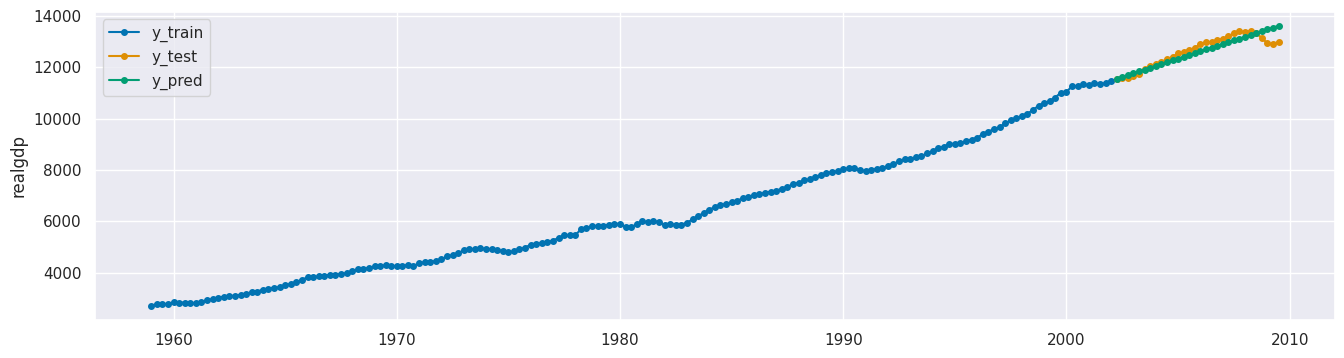

In [87]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);